In [3]:
import matplotlib.pyplot as plot
import matplotlib.image as mpimg
import numpy as numpy
import math

** Initalize lines **

In [4]:
numpy.random.seed(21)

left_lane_lines = numpy.random.randint(3, 15 + 1)
right_lane_lines = numpy.random.randint(3, 15 + 1)
noise_lines = numpy.random.randint(2, 10 + 1)

print('Lines: left - ', left_lane_lines, '; right - ', right_lane_lines, '; noise - ', noise_lines)

Lines: left -  12 ; right -  11 ; noise -  6


** initialize angles **

In [7]:
left_line_angles = numpy.random.normal(45, 3, left_lane_lines).astype(int)
right_line_angles = numpy.random.normal(135, 3, right_lane_lines).astype(int)
noise_line_angles = numpy.random.randint(0, 180 + 1, noise_lines)

** initialize lengths **

In [ ]:
left_line_length = numpy.random.randint(5, 100, left_lane_lines)
right_line_length = numpy.random.randint(5, 100, right_lane_lines)
noise_line_length = numpy.random.randint(5, 100, noise_lines)

** initialize coordinates **

In [51]:
# assume that our target values are 100 and 200
left_line_coords = numpy.random.normal(100, 10, left_lane_lines).astype(int)
right_lane_coords = numpy.random.normal(200, 10, right_lane_lines).astype(int)
noise_line_coords = numpy.random.randint(0, 500 + 1, noise_lines)

** merge angles with lengths **

In [27]:
# get array of [angle, length, OX_coord]
def merge(*pairs):
    result = None
    for pair in pairs:
        for source, *values in pair:
            merged = source[:, None]
            for value in values:
                merged = numpy.append(merged, value[:, None], axis=1)
            result = merged if result is None else numpy.concatenate((merged, result), axis=0)
    return result

pairs = [
    [noise_line_angles, noise_line_length, noise_line_coords],
    [left_line_angles, left_line_length, left_line_coords],
    [right_line_angles, right_line_length, right_lane_coords]
]
lines = merge(pairs)
numpy.random.shuffle(lines)


** Analysis logic **

In [47]:
# Neighboors function is used to convolve own values with values of cell's neighboors. The principle is:
# "it's better to have a lot of lines with similar angle values (even if they are short), than be a long single one"
def neighboors(quantity_array, weights_array, frame_size, neighboors_length_weight=0.7):
    frame_size += 1
    
    neighboors_info = []
    size = quantity_array.size
    neighboors_quantity_max = 0
    
    for index in range(size):
        neighboors_weight = 0
        neighboors_quantity = 0
        
        for i in range(index - frame_size + 1, index):
            if (i > 0):
                neighboors_quantity += quantity_array[i]
                neighboors_weight += weights_array[i]
            
        for i in range(index + 1, index + frame_size):
            if (i < size - 1):
                neighboors_quantity += quantity_array[i]
                neighboors_weight += weights_array[i]
        
        if (neighboors_quantity_max < neighboors_quantity):
            neighboors_quantity_max = neighboors_quantity

        neighboors_info.append([neighboors_quantity, neighboors_weight])
    
    total_weights = []
    for info in neighboors_info:
        quantity, weight = info
        total_weight = neighboors_length_weight * weight * quantity / neighboors_quantity_max
        total_weights.append(total_weight)

    return numpy.array(total_weights).astype(int)

def normalize(array, base=100):
    max_value = max(array)
    return array * base / max_value

def moving_average(a, n=3) :
    ret = numpy.cumsum(a, dtype=int)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# once we haved smoothed distribution we need to get peak values
def find_peaks(array, threshold):
    peaks = []
    threshold_value = max(array) * threshold
    arr_length = len(array)
    for i in range(arr_length):
        if i - 1 < 0 or i + 1 >= arr_length:
            continue
        if array[i] > threshold_value and array[i-1] < array[i] and array[i] > array[i+1]:
            peaks.append(i)
    return peaks

# find coordinates where line with particular angle would start (on the OX axis ~ the very bottom row of image)
def get_coords(lines, target_angles, frame_size=5):
    lines_crosses = []
    coords = []
    angles_total = len(target_angles)
    for i in range(angles_total):
        lines_crosses.append([])
        
    for line in lines:
        angle, length, coord = line
        for i in range(angles_total):
            target_angle = target_angles[i]
            current_angle_coords = lines_crosses[i]
            if target_angle - frame_size <= angle <= target_angle + frame_size:
                current_angle_coords.append(coord)
                
#     it seems like we can improve algorithm here via distribution and neighboors instead of averaging
    for angle_coords in lines_crosses:
        coords.append(numpy.average(angle_coords).astype(int))  
    return coords

** Evaluate calculations **

In [49]:
BINS = 180
RANGE = (0, 180)
OWN_LENGTH_WEIGHT = 0.4

# finding angles
quantity_histogram = numpy.histogram(lines[:,0], bins=BINS, range=RANGE)[0]
length_weights = (lines[:,1] * OWN_LENGTH_WEIGHT).astype(int)
own_weights_histogram = numpy.histogram(
    lines[:,0],
    bins=BINS,
    range=RANGE,
    weights=length_weights
)[0]

neighboors_weights_histogram = neighboors(quantity_histogram, own_weights_histogram, 5)
result = neighboors_weights_histogram + own_weights_histogram
smoothed_result = moving_average(result, n=5)
normalized_result = normalize(smoothed_result)
target_angles = find_peaks(normalized_result, .5)

coords = get_coords(lines, target_angles)

** Display results **

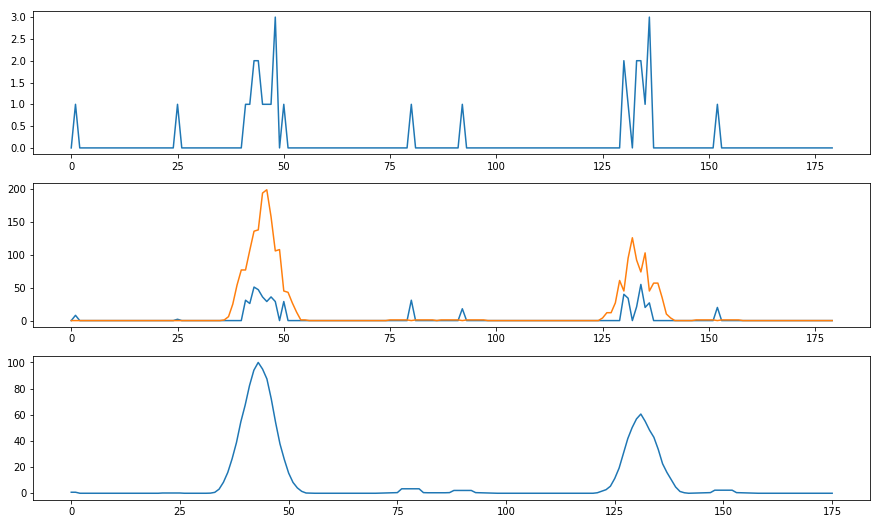

Angles are: [43, 131]
Coordinates are: [99, 198]


In [50]:
plot.figure(figsize=(15, 9))

# show  distribution
plot.subplot(311)
plot.plot(quantity_histogram)

# show weighted distribution
plot.subplot(312)
plot.plot(own_weights_histogram)
plot.plot(neighboors_weights_histogram)

# show results
plot.subplot(313)
plot.plot(normalized_result)

plot.show()
print('Angles are:', target_angles)
print('Coordinates are:', coords)